**Import Libraries, load the data**

In [4]:
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)
from datetime import timedelta
import warnings
import mysql.connector

warnings.filterwarnings("ignore")

connection = mysql.connector.connect(
    port="3307",
    user="root",
    password="dev",
    database="soccer_dwh"
)

cursor = connection.cursor()


#load data (make sure you have downloaded database.sqlite)

matches = pd.read_sql_query("SELECT * from `match_goals_fact`", connection)
leagues = pd.read_sql_query("SELECT * from league_dim", connection)
teams = pd.read_sql_query("SELECT * from team_dim", connection)


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns  #Visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


In [14]:
leages_by_season = pd.read_sql("""SELECT league_dim.country_name, league_dim.name, period as season,
                               count(distinct stage) AS number_of_stages,
                                count(distinct HT.long_name) AS number_of_teams,
                                avg(goal_for) AS avg_home_team_scores, 
                                avg(goal_against) AS avg_away_team_goals, 
                                avg(goal_for-goal_against) AS avg_goal_dif, 
                                avg(goal_for+goal_against) AS avg_goals, 
                                sum(goal_for+goal_against) AS total_goals                                      
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE league_dim.country_name in ('Spain', 'Germany', 'France', 'Italy', 'England')
                                GROUP BY league_dim.country_name, league_dim.name, season
                                HAVING count(distinct stage) > 10
                                ORDER BY league_dim.country_name, league_dim.name, season DESC
                                ;""", connection)
leages_by_season

,country_name,name,season,number_of_stages,number_of_teams,avg_home_team_scores,avg_away_team_goals,avg_goal_dif,avg_goals,total_goals
0,England,England Premier League,2015/2016,38,20,3.1711,2.5605,0.6105,5.7316,2178.0
1,England,England Premier League,2014/2015,38,20,3.0737,2.3053,0.7684,5.3789,2044.0
2,England,England Premier League,2013/2014,38,20,3.5842,2.6921,0.8921,6.2763,2385.0
3,England,England Premier League,2012/2013,38,20,3.3289,2.8316,0.4974,6.1605,2341.0
4,England,England Premier League,2011/2012,38,20,3.3789,2.6316,0.7474,6.0105,2284.0
5,England,England Premier League,2010/2011,38,20,3.4368,2.5421,0.8947,5.9789,2272.0
6,England,England Premier League,2009/2010,38,20,3.6132,2.3342,1.2789,5.9474,2260.0
7,England,England Premier League,2008/2009,38,20,2.8947,2.2237,0.6711,5.1184,1945.0
8,France,France Ligue 1,2015/2016,38,20,3.0395,2.2921,0.7474,5.3316,2026.0
9,France,France Ligue 1,2014/2015,38,20,2.8632,2.1474,0.7158,5.0105,1904.0


<Axes: title={'center': 'Average Goals per Game Over Time'}>

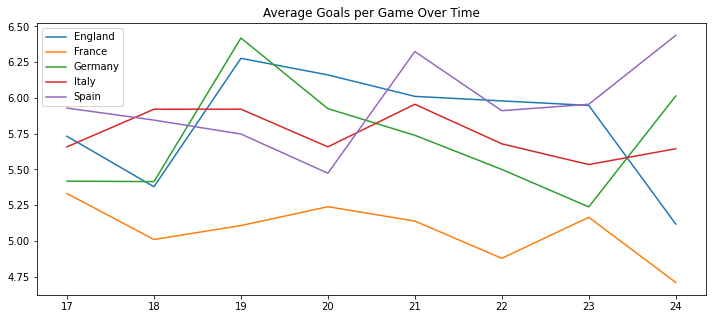

In [12]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goals'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goals'])

df.plot(figsize=(12,5),title='Average Goals per Game Over Time')

<Axes: title={'center': 'Average Goals Difference Home vs Out'}>

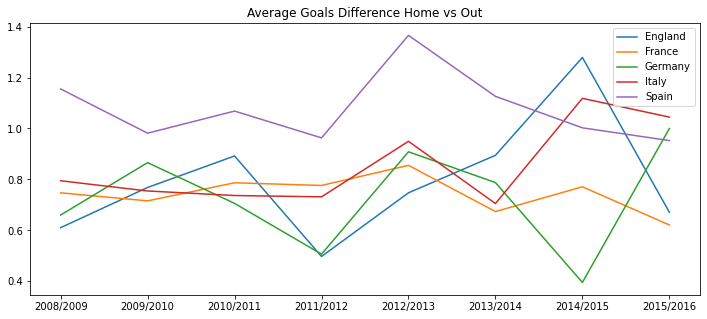

In [16]:
df = pd.DataFrame(index=np.sort(leages_by_season['season'].unique()), columns=leages_by_season['country_name'].unique())

df.loc[:,'Germany'] = list(leages_by_season.loc[leages_by_season['country_name']=='Germany','avg_goal_dif'])
df.loc[:,'Spain']   = list(leages_by_season.loc[leages_by_season['country_name']=='Spain','avg_goal_dif'])
df.loc[:,'France']   = list(leages_by_season.loc[leages_by_season['country_name']=='France','avg_goal_dif'])
df.loc[:,'Italy']   = list(leages_by_season.loc[leages_by_season['country_name']=='Italy','avg_goal_dif'])
df.loc[:,'England']   = list(leages_by_season.loc[leages_by_season['country_name']=='England','avg_goal_dif'])

df.plot(figsize=(12,5),title='Average Goals Difference Home vs Out')

****List of Matches****

In this exapmle we will show only the columns that interests us, so instead of * we will use the exact names.

Some of the cells have the same name (Country.name,League.name). We will rename them using AS.

As you can see, this query has much more joins. The reasons is because the DB is designed in a star structure - one table (Match) with all the "performance" and metrics, but only keys and IDs, while all the descriptive information stored in other tables (Country, League, Team)
And then I am creating different tables for all the leagues from the dataset matches which I'll later store in Matches.

In [34]:
matches_Spain = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                        
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Spain' 
                                ORDER by date
                               ;""", connection)
#matches.head() #It gives us first 5 matches in Spanish League in season 2008/09

matches_Eng = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                         
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'England' 
                                ORDER by date
                               ;""", connection)

matches_Ger = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                          
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Germany' 
                                ORDER by date
                               ;""", connection)

matches_Por = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                         
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Portugal' 
                                ORDER by date
                               ;""", connection)

matches_Italy = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                        
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Italy' 
                                ORDER by date
                               ;""", connection)

matches_France = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                         
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'France' 
                                ORDER by date
                               ;""", connection)

matches_Bel = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                         
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Belgium' 
                                ORDER by date
                               ;""", connection)

matches_Ned = pd.read_sql("""SELECT 
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                         
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Netherlands' 
                                ORDER by date
                               ;""", connection)

matches_Pol = pd.read_sql("""SELECT
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                       
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Poland' 
                                ORDER by date
                               ;""", connection)

matches_Scot = pd.read_sql("""SELECT
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                        
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Scotland' 
                                ORDER by date
                               ;""", connection)

matches_Swt = pd.read_sql("""SELECT
                            league_dim.country_name AS country_name, 
                            league_dim.name AS league_name, 
                            period, 
                            stage, 
                            date,
                            HT.long_name AS  home_team,
                            AT.long_name AS away_team,
                            goal_for, 
                            goal_against                                        
                                FROM match_goals_fact
                                JOIN league_dim on league_dim.id = match_goals_fact.league
                                JOIN season_dim on season_dim.id = match_goals_fact.season
                                LEFT JOIN team_dim AS HT on HT.id = match_goals_fact.home_team
                                LEFT JOIN team_dim AS AT on AT.id = match_goals_fact.away_team
                                WHERE country_name = 'Switzerland' 
                                ORDER by date
                               ;""", connection)

**Making a list of all the leagues matches**

So here we created a list of matches in all respective leagues so that we can iterate over all the leagues to do other calculations easily.

In [35]:
matches = [matches_Spain,matches_Eng,matches_Italy,matches_Ger,matches_Por,matches_France,matches_Swt,matches_Pol,matches_Scot,matches_Ned,matches_Bel]
matches


[     country_name      league_name     period  stage        date  \
 0           Spain  Spain LIGA BBVA  2008/2009      1  2008-08-30   
 1           Spain  Spain LIGA BBVA  2008/2009      1  2008-08-30   
 2           Spain  Spain LIGA BBVA  2008/2009      1  2008-08-31   
 3           Spain  Spain LIGA BBVA  2008/2009      1  2008-08-31   
 4           Spain  Spain LIGA BBVA  2008/2009      1  2008-08-31   
 ...           ...              ...        ...    ...         ...   
 3035        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
 3036        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
 3037        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
 3038        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
 3039        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
 
                       home_team        away_team  goal_for  goal_against  
 0                   Valencia CF     RCD Mallorca         3             0  
 1                

In [36]:
def goal_diff(fun):
    for i in fun:
        i['goal_diff'] = i['goal_for']-i['goal_against']
        print(i.tail())

goal_diff(matches)  

     country_name      league_name     period  stage        date  \
3035        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
3036        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
3037        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
3038        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   
3039        Spain  Spain LIGA BBVA  2015/2016     38  2016-05-15   

                   home_team      away_team  goal_for  goal_against  goal_diff  
3035  Real Sporting de Gijón  Villarreal CF         2             0          2  
3036     Real Betis Balompié      Getafe CF         2             1          1  
3037            RCD Espanyol       SD Eibar         5             2          3  
3038               Málaga CF  UD Las Palmas         7             2          5  
3039          Rayo Vallecano     Levante UD         3             1          2  
     country_name             league_name     period  stage        date  \
3035      England  England Pre

In [37]:
def des_stats(fun):
    for i in fun:
        print(i.country_name[0])
        print('')
        print('Mean')
        print('Home Goals =',i['goal_for'].mean())
        print('Away Goals =',i['goal_against'].mean())
        print('Goal Diff =',i['goal_diff'].mean())
        print('')
        print('Standard Deviation')
        print('Home Goals =',i['goal_for'].std())
        print('Away Goals =',i['goal_against'].std())
        print('Goal Diff =',i['goal_diff'].std())
        print('\n')

        
des_stats(matches)

Spain

Mean
Home Goals = 3.5148026315789473
Away Goals = 2.437828947368421
Goal Diff = 1.0769736842105264

Standard Deviation
Home Goals = 2.4976022645578757
Away Goals = 1.807287510185563
Goal Diff = 3.0353835333343344


England

Mean
Home Goals = 3.310197368421053
Away Goals = 2.5151315789473685
Goal Diff = 0.7950657894736842

Standard Deviation
Home Goals = 2.267739028911996
Away Goals = 1.963411951527559
Goal Diff = 2.8020890755844543


Italy

Mean
Home Goals = 3.2993039443155454
Away Goals = 2.445475638051044
Goal Diff = 0.8538283062645011

Standard Deviation
Home Goals = 2.161939317103179
Away Goals = 1.7799428453311887
Goal Diff = 2.599896593221579


Germany

Mean
Home Goals = 3.218545751633987
Away Goals = 2.489787581699346
Goal Diff = 0.7287581699346405

Standard Deviation
Home Goals = 2.2653984749840546
Away Goals = 1.8195847648870624
Goal Diff = 2.8674501391133242


Portugal

Mean
Home Goals = 2.5107066381156318
Away Goals = 2.040149892933619
Goal Diff = 0.47055674518201285


In [38]:
def result(fun):
    for i in fun:
        i['win'] = ((i['goal_diff']>0)*1)
        i['draw'] = ((i['goal_diff']==0)*1)
        i['lose'] = ((i['goal_diff']<0)*1)
        print(i.country_name[0])
        print('')
        print('win =' ,(i['win'].mean())*100,'%')
        print('draw =',(i['draw'].mean())*100,'%')
        print('lose =',(i['lose'].mean())*100,'%')
        print('\n')
    
result(matches)


Spain

win = 55.328947368421055 %
draw = 13.980263157894738 %
lose = 30.69078947368421 %


England

win = 53.815789473684205 %
draw = 16.348684210526315 %
lose = 29.835526315789473 %


Italy

win = 53.49685117666556 %
draw = 15.909844216108718 %
lose = 30.59330460722572 %


Germany

win = 50.36764705882353 %
draw = 16.544117647058822 %
lose = 33.088235294117645 %


Portugal

win = 47.109207708779444 %
draw = 20.931477516059957 %
lose = 31.959314775160603 %


France

win = 52.86184210526316 %
draw = 18.059210526315788 %
lose = 29.078947368421055 %


Switzerland

win = 54.04040404040404 %
draw = 11.688311688311687 %
lose = 34.271284271284266 %


Poland

win = 52.38095238095239 %
draw = 18.042328042328045 %
lose = 29.57671957671958 %


Scotland

win = 47.14912280701755 %
draw = 13.760964912280702 %
lose = 39.08991228070175 %


Netherlands

win = 55.46810273405137 %
draw = 14.95443247721624 %
lose = 29.577464788732392 %


Belgium

win = 56.438026474127554 %
draw = 13.959085439229844 %
lose

In [40]:
list_win = []
for i in matches:
    list_win.append(i['win'].mean())
#print(list_win) 


list_draw = []
for i in matches:
    list_draw.append(i['draw'].mean())
#print(list_draw)

list_lose = []
for i in matches:
    list_lose.append(i['lose'].mean())
    #print(list_lose)

list_countries = []

for i in matches:
    list_countries.append(i['country_name'][0])
    
#print(list_countries)    

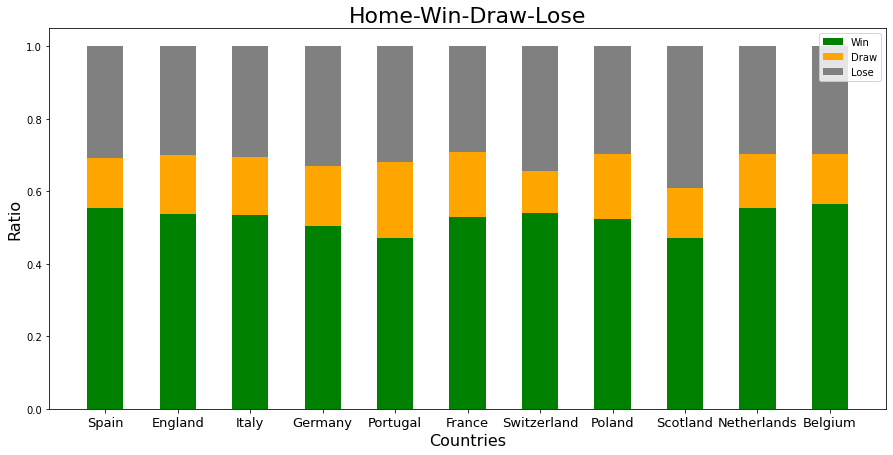

In [41]:
plt.figure(figsize = (15,7))

x = np.arange(len(list_win))

plt.bar(x,list_win,color='green', width = 0.5,label = 'Win')
plt.bar(x,list_draw,color= 'orange',bottom = list_win,width = 0.5,label = 'Draw')
plt.bar(x,list_lose,color= 'grey',bottom =[x+y for x,y in zip(list_win,list_draw)],width = 0.5,label = 'Lose')

#label

plt.xticks(x,list_countries, fontsize = 13)
plt.title('Home-Win-Draw-Lose',fontsize = 22)
plt.xlabel('Countries', fontsize = 16)
plt.ylabel('Ratio', fontsize = 16)


plt.legend(loc = 'upper right')

plt.savefig('Win_Draw_Lose.png')
plt.show()

In [42]:
for i in matches:
    i['winner'] = np.where(i['win']==1, i['home_team'],i['away_team'])

In [43]:
top_teams_Spain = pd.crosstab(index = matches_Spain['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Eng = pd.crosstab(index = matches_Eng['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Ger = pd.crosstab(index = matches_Ger['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_France = pd.crosstab(index = matches_France['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Italy = pd.crosstab(index = matches_Italy['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Pol = pd.crosstab(index = matches_Pol['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Swt = pd.crosstab(index = matches_Swt['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Ned = pd.crosstab(index = matches_Ned['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Scot = pd.crosstab(index = matches_Scot['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Por = pd.crosstab(index = matches_Por['winner'], columns = 'count').nlargest(10,'count')['count']
top_teams_Bel = pd.crosstab(index = matches_Bel['winner'], columns = 'count').nlargest(10,'count')['count']

top_teams = [top_teams_Spain,top_teams_Eng,top_teams_Ger,top_teams_France,top_teams_Italy,top_teams_Pol,top_teams_Swt,
            top_teams_Ned,top_teams_Scot,top_teams_Por,top_teams_Bel]

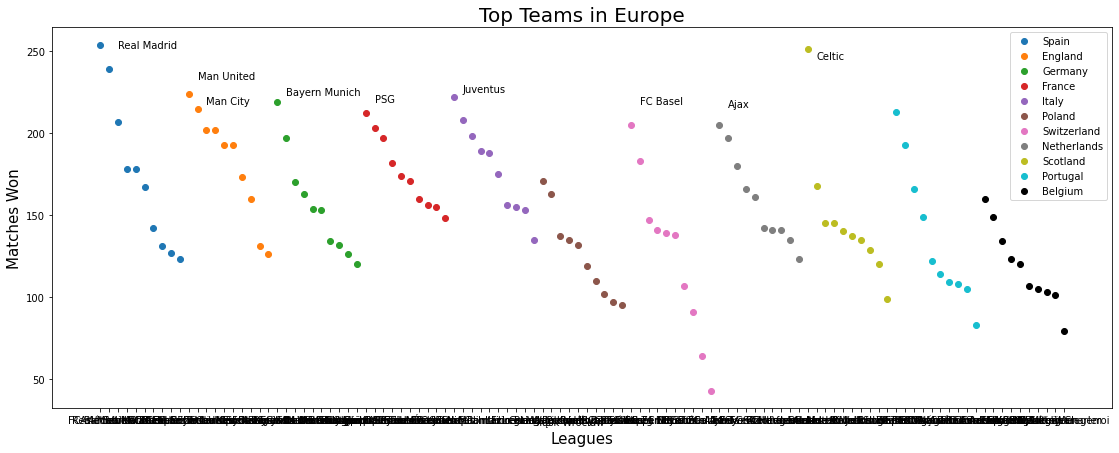

In [44]:
plt.figure(figsize=(19,7))
#defining all the plots with respect to all the leagues
ax1 = plt.plot(top_teams_Spain,'o',label = 'Spain');
ax2 = plt.plot(top_teams_Eng,'o',label = 'England');
ax3 = plt.plot(top_teams_Ger,'o',label = 'Germany');
ax4 = plt.plot(top_teams_France,'o',label = 'France');
ax5 = plt.plot(top_teams_Italy,'o',label = 'Italy');
ax6 = plt.plot(top_teams_Pol,'o',label = 'Poland');
ax7 = plt.plot(top_teams_Swt,'o',label = 'Switzerland');
ax8 = plt.plot(top_teams_Ned,'o',label = 'Netherlands');
ax9 = plt.plot(top_teams_Scot,'o',label = 'Scotland');
ax10 = plt.plot(top_teams_Por,'o',label = 'Portugal');
ax11 = plt.plot(top_teams_Bel,'ko',label = 'Belgium');
plt.legend(loc = 'best');
plt.title('Top Teams in Europe', fontsize= 20)
plt.xlabel('Leagues',fontsize = 15)
plt.ylabel('Matches Won',fontsize = 15)

#Annotations for to Top Ten Teams
plt.annotate('Barcelona',(1,265))
plt.annotate('Real Madrid',(2,252))
plt.annotate('Celtic',(81,245))
plt.annotate('Man United',(11,233))
plt.annotate('Juventus',(41,225))
plt.annotate('Bayern Munich',(21,223))
plt.annotate('PSG',(31,219))
plt.annotate('Man City',(12,218))
plt.annotate('FC Basel',(61,218))
plt.annotate('Ajax',(71,216))



plt.savefig('Top Teams in Europe.png')
    

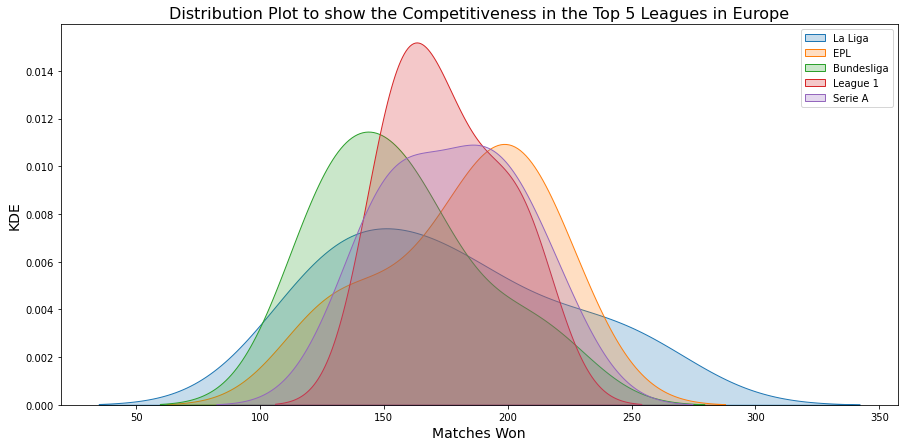

In [45]:

plt.figure(figsize=(15, 7))
ax1 = sns.kdeplot(top_teams_Spain, label='La Liga', fill=True)
ax2 = sns.kdeplot(top_teams_Eng, label='EPL', fill=True)
ax3 = sns.kdeplot(top_teams_Ger, label='Bundesliga', fill=True)
ax4 = sns.kdeplot(top_teams_France, label='League 1', fill=True)
ax5 = sns.kdeplot(top_teams_Italy, label='Serie A', fill=True)

plt.title('Distribution Plot to show the Competitiveness in the Top 5 Leagues in Europe', fontsize=16)
plt.xlabel('Matches Won', fontsize=14)
plt.ylabel('KDE', fontsize=14)
plt.legend()

plt.savefig('Competitiveness in the Top 5 Leagues in Europe.png')
plt.show()
